In [1]:

# What version of Python do you have?
import sys

# import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import keras
tf.keras.backend.clear_session()

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Tensor Flow Version: 2.1.0
Keras Version: 2.3.1

Python 3.7.10 (default, Feb 26 2021, 13:06:18) [MSC v.1916 64 bit (AMD64)]
Pandas 1.2.4
Scikit-Learn 0.24.1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Using TensorFlow backend.


GPU is available


In [2]:
import os
# os.chdir(r"C:\Users\sella\Documents")
#os.chdir(r'/home/said.mejia/Projects/Deep_Learning/Dataset')

In [3]:
import sys
sys.path
# sys.path.append(r'D:\Users\juanp\Documents\NeuralNetworks\final-project-landandbuildingsatimg-ccny\data\packages\image-segmentation-keras-master\image-segmentation-keras-master')
sys.path.append('../../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import PIL # pillow - image processing
import tensorflow as tf
from PIL import Image
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib
import matplotlib.pyplot as plt

from src.models.keras_segmentation.models.unet import resnet50_unet, vgg_unet
# from image_segmentation.keras_segmentation.models.unet import resnet50_unet, vgg_unet
from src.visualization import visualize
from keras.optimizers import Adam

tf.random.set_seed(123)
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.9  # 0.6 sometimes works better for folks
# tf.keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

bal_train_data_dir = 'D:/Users/juanp/Documents/NeuralNetworks/final-project-landandbuildingsatimg-ccny/data/processed/Balanced_80/train'
bal_val_data_dir = 'D:/Users/juanp/Documents/NeuralNetworks/final-project-landandbuildingsatimg-ccny/data/processed/Balanced_80/val'


out_train_data_dir = 'D:/Users/juanp/Documents/NeuralNetworks/final-project-landandbuildingsatimg-ccny/data/processed/Cropped_same_name/train'
out_val_data_dir = 'D:/Users/juanp/Documents/NeuralNetworks/final-project-landandbuildingsatimg-ccny/data/processed/Cropped_same_name/val'
out_test_data_dir = 'D:/Users/juanp/Documents/NeuralNetworks/final-project-landandbuildingsatimg-ccny/data/processed/Cropped_same_name/test'

Segmentation Models: using `keras` framework.


# GPU

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")    
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
    
tf.config.set_soft_device_placement(True)

1 Physical GPUs, 1 Logical GPU


In [5]:
folder_name = 'Save_Weights'
# os.mkdir(r'../../models/'f'{folder_name}')

# Building the Resnet_Unet

In [6]:
model = vgg_unet(n_classes=7 , input_height=512, input_width=512)
# model.summary()

In [9]:
weight_path= ['Model_Best_Weights_vgg_unet_weights_60_2.hdf5',
             'Model_Best_Weights_resnet50_unet.hdf5',
             'Model_Best_Weights_vgg_segnet.hdf5',
             'Model_Best_Weights_resnet50_segnet.hdf5']
i = 0

In [10]:
callbacks = [
    ModelCheckpoint(monitor='val_iou_score',
                filepath= '../../models/'f'{folder_name}''/' + weight_path[i],
                        save_best_only=True,
                        verbose=1, mode = 'max'), 
    EarlyStopping(monitor='val_iou_score',patience=10,
                           restore_best_weights=True,
                           mode='max'),
    ReduceLROnPlateau(monitor='val_iou_score', factor=0.5,
                              patience=3, min_lr=0.00001)
]

In [11]:
# callbacks = [
#     ModelCheckpoint(monitor='val_iou_score',
#                 filepath= "D:/Users/juanp/Documents/NeuralNetworks/final-project-landandbuildingsatimg-ccny/data/Weigths/VGG_UNET/Trial_2/" + 'model_weights_best_Sample_Weight.hdf5',
#                         save_best_only=True,
#                         verbose=1, mode = 'max'), 
#     EarlyStopping(monitor='val_iou_score',
#                   patience=10,
#                            restore_best_weights=False,
#                            mode='max'), ReduceLROnPlateau()
# ]

In [12]:
callbacks

In [14]:
from datetime import datetime
start = datetime.now()
total_loss, optim, metrics,  train_gen,  steps_per_epoch, val_gen, val_steps_per_epoch, epochs, callbacks, gen_use_multiprocessing, initial_epoch = model.train(
    input_height = 612,
    input_width = 612,
    verify_dataset = False,
    train_images =  f"{out_train_data_dir}/Images/",
    train_annotations = f"{out_train_data_dir}/Masks/",
    validate= True,
    val_images =  f"{out_val_data_dir}/Images/",
    val_annotations = f"{out_val_data_dir}/Masks/",
    epochs=100, 
    callbacks = callbacks,
    other_inputs_paths=[f"{out_train_data_dir}/Sample_Weights/"]
)
end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))


Time Taken for testing: 0:00:00.000950


In [15]:
# model = vgg_unet(n_classes=7 , input_height=512, input_width=512)
#model.summary()
# optima = keras.optimizers.Adam(lr = 0.0001)
optima = Adam(lr=0.0001)
model.compile(loss=total_loss, optimizer= optima, metrics= metrics)

In [ ]:
nn_model = model.fit(train_gen,
                  steps_per_epoch=steps_per_epoch,
                  validation_data=val_gen,
                  validation_steps=val_steps_per_epoch,
                  epochs=epochs, callbacks=callbacks,
                  use_multiprocessing=gen_use_multiprocessing, initial_epoch=initial_epoch) 

Epoch 1/100
512/512 [==============================] - 331s 647ms/step - loss: 0.5052 - iou_score: 0.3767 - f1-score: 0.5204 - val_loss: 0.4143 - val_iou_score: 0.4621 - val_f1-score: 0.6030

Epoch 00001: val_iou_score improved from -inf to 0.46208, saving model to ../../models/Save_Weights/Model_Best_Weights_vgg_unet_weights_60_2.hdf5
Epoch 2/100
512/512 [==============================] - 320s 625ms/step - loss: 0.4612 - iou_score: 0.4476 - f1-score: 0.5882 - val_loss: 0.0471 - val_iou_score: 0.5198 - val_f1-score: 0.6513

Epoch 00002: val_iou_score improved from 0.46208 to 0.51978, saving model to ../../models/Save_Weights/Model_Best_Weights_vgg_unet_weights_60_2.hdf5
Epoch 3/100
512/512 [==============================] - 326s 636ms/step - loss: 0.4056 - iou_score: 0.4978 - f1-score: 0.6340 - val_loss: 0.4133 - val_iou_score: 0.5682 - val_f1-score: 0.6964

Epoch 00003: val_iou_score improved from 0.51978 to 0.56819, saving model to ../../models/Save_Weights/Model_Best_Weights_vgg_une

In [ ]:
# Save the model and the weights
model.save('D:/Users/juanp/Documents/NeuralNetworks/final-project-landandbuildingsatimg-ccny/data/Weigths/VGG_UNET/vgg_unet_Sample_Weight.h5')

# Changing File names

## Test

In [6]:
# direc = "Cropped_same_name\\test\\Images\\"
# reading_images = []
# reading_masks = []

# reading_images = glob.glob(r'Cropped\test\images\*.png')
# reading_masks = glob.glob(r'Cropped\test\masks\*.png')

# print(reading_images[0:1])
# print(reading_masks[0:1])

# print(len(reading_images))
# print(len(reading_masks))

In [7]:
# name_images = []
# for i, r in enumerate(reading_images):
#     name_images.append(reading_images[i][26:])
# print(name_images[0:1])
# print(len(name_images))

In [8]:
# for i, filename in enumerate(reading_images):
#     os.rename(filename, "Cropped_same_name\\test\\Images\\" + name_images[i])
# for i, filename in enumerate(reading_masks):
#     os.rename(filename, "Cropped_same_name\\test\\Masks\\" + name_images[i])

In [9]:
# name_images = reading_images[0][26:]
# name_images

## train

In [10]:
# direc = "Cropped_same_name\\train\\Images\\"
# reading_images = []
# reading_masks = []

# reading_images = glob.glob(r'Cropped\train\images\*.png')
# reading_masks = glob.glob(r'Cropped\train\masks\*.png')

# print(reading_images[0:1])
# print(reading_masks[0:1])

# print(len(reading_images))
# print(len(reading_masks))

In [11]:
# name_images = []
# for i, r in enumerate(reading_images):
#     name_images.append(reading_images[i][27:])
# print(name_images[0:1])
# print(len(name_images))

In [12]:
# for i, filename in enumerate(reading_images):
#     os.rename(filename, "Cropped_same_name\\train\\Images\\" + name_images[i])
# for i, filename in enumerate(reading_masks):
#     os.rename(filename, "Cropped_same_name\\train\\Masks\\" + name_images[i])

### Validation

In [13]:
# direc = "Cropped_same_name\\val\\Images\\"
# reading_images = []
# reading_masks = []

# reading_images = glob.glob(r'Cropped\val\images\*.png')
# reading_masks = glob.glob(r'Cropped\val\masks\*.png')

# print(reading_images[0:1])
# print(reading_masks[0:1])

# print(len(reading_images))
# print(len(reading_masks))

In [14]:
# name_images = []
# for i, r in enumerate(reading_images):
#     name_images.append(reading_images[i][25:])
# print(name_images[0:1])
# print(len(name_images))

In [15]:
# for i, filename in enumerate(reading_images):
#     os.rename(filename, "Cropped_same_name\\val\\Images\\" + name_images[i])
# for i, filename in enumerate(reading_masks):
#     os.rename(filename, "Cropped_same_name\\val\\Masks\\" + name_images[i])

# Cropping Images

## Test

In [16]:
# reading_images = glob.glob(r'Cropped_same_name\test\Images\*.png')
# reading_masks = glob.glob(r'Cropped_same_name\test\Masks\*.png')

# print(reading_images[5])
# print(reading_masks[0:1])

In [17]:
# for i in reading_images:
#     im_image = Image.open(i)
#     # im_image.show()
#     cropped_image =  im_image.crop((0,0,512,512))
#     # cropped_image.show()
#     cropped_image.save(i.replace('Cropped_same_name','Cropped_same_name_cropped'))
    
# for i in reading_masks:
#     im_mask = Image.open(i)
#     # im_image.show()
#     cropped_mask =  im_mask.crop((0,0,512,512))
#     # cropped_image.show()
#     cropped_mask.save(i.replace('Cropped_same_name','Cropped_same_name_cropped'))

## Train

In [18]:
# reading_images = glob.glob(r'Cropped_same_name\train\Images\*.png')
# reading_masks = glob.glob(r'Cropped_same_name\train\Masks\*.png')

# print(reading_images[5])
# print(reading_masks[0:1])

In [19]:
# for i in reading_images:
#     im_image = Image.open(i)
#     # im_image.show()
#     cropped_image =  im_image.crop((0,0,512,512))
#     # cropped_image.show()
#     cropped_image.save(i.replace('Cropped_same_name','Cropped_same_name_cropped'))
    
# for i in reading_masks:
#     im_mask = Image.open(i)
#     # im_image.show()
#     cropped_mask =  im_mask.crop((0,0,512,512))
#     # cropped_image.show()
#     cropped_mask.save(i.replace('Cropped_same_name','Cropped_same_name_cropped'))

## Validation

In [20]:
# reading_images = glob.glob(r'Cropped_same_name\val\Images\*.png')
# reading_masks = glob.glob(r'Cropped_same_name\val\Masks\*.png')

# print(reading_images[5])
# print(reading_masks[0:1])

In [21]:
# for i in reading_images:
#     im_image = Image.open(i)
#     # im_image.show()
#     cropped_image =  im_image.crop((0,0,512,512))
#     # cropped_image.show()
#     cropped_image.save(i.replace('Cropped_same_name','Cropped_same_name_cropped'))
    
# for i in reading_masks:
#     im_mask = Image.open(i)
#     # im_image.show()
#     cropped_mask =  im_mask.crop((0,0,512,512))
#     # cropped_image.show()
#     cropped_mask.save(i.replace('Cropped_same_name','Cropped_same_name_cropped'))

# Reading an image

In [6]:
reading_images = glob.glob(f'{out_train_data_dir}/Images/*.png')
reading_images[5]

'D:/Users/juanp/Documents/NeuralNetworks/final-project-landandbuildingsatimg-ccny/data/processed/Cropped_same_name/train/Images\\Batch_0_Image_0_Tile_15.png'

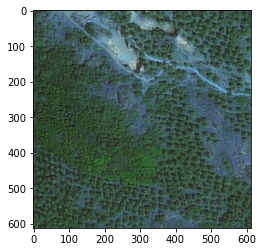

In [24]:
img = PIL.Image.open(reading_images[0], 'r')
plt.imshow(np.asarray(img))

In [25]:
image_array =  np.asarray(img)
image_array.shape

(612, 612, 3)

In [29]:
reading_mask = glob.glob(f'{out_train_data_dir}/Masks/*.png')
reading_mask[0]

'D:\\Users\\juanp\\Documents\\NeuralNetworks\\final-project-landandbuildingsatimg-ccny\\data\\processed\\Cropped_same_name\\train\\Masks\\Batch_0_Image_0_Tile_0.png'

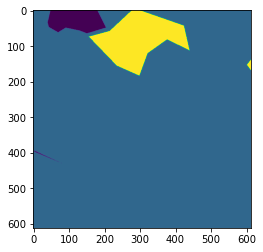

In [27]:
img = PIL.Image.open(reading_mask[0], 'r')
plt.imshow(np.asarray(img))

In [28]:
image_array =  np.asarray(img)
image_array.shape

(612, 612)

# Building the Resnet_Unet

In [5]:
model = resnet50_unet(n_classes=7 , input_height=512, input_width=512)
# model.summary()

In [36]:
# callbacks = [ModelCheckpoint(filepath=r'Cropped_same_name/Model_Save/Version3/Trial_1/model_weights_best.hdf5',
#                         monitor='val_categorical_accuracy',
#                         save_best_only=True,
#                         verbose=1), 
#              EarlyStopping(monitor='val_categorical_accuracy',
#                            patience=8,
#                            restore_best_weights=True,
#                            mode='max')]

In [6]:
callbacks = [
    ModelCheckpoint(
                filepath="D:/Users/juanp/Documents/NeuralNetworks/final-project-landandbuildingsatimg-ccny/data/Weigths/Resnet50_Unet/Trial_2/" + 'model_weights_best_val_bal.hdf5',
                        save_best_only=True,
                        verbose=1)
            ,
    EarlyStopping(patience=8,
                           restore_best_weights=True,
                           mode='max')
]

In [7]:
callbacks

In [7]:
from datetime import datetime
start = datetime.now()
model_resnet50_unet = model.train(
    input_height = 612,
    input_width = 612,
    verify_dataset = False,
    train_images =  f"{bal_train_data_dir}/Images/",
    train_annotations = f"{bal_train_data_dir}/Masks/",
    validate= True,
    val_images =  f"{bal_val_data_dir}/Images/",
    val_annotations = f"{bal_val_data_dir}/Masks/",
    epochs=50, 
    callbacks = callbacks
)
end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))

Epoch 1/50
 15/512 [..............................] - ETA: 10:57 - loss: 0.9052 - iou_score: 0.0419 - f1-score: 0.0797

KeyboardInterrupt: 

In [33]:
# Save the model and the weights
model.save('D:/Users/juanp/Documents/NeuralNetworks/final-project-landandbuildingsatimg-ccny/data/Weigths/Resnet50_Unet/resnet50_ungget_bal_val.h5')

In [19]:
def plot_history(history):
       
    acc = history.history['f1-score']
    val_acc = history.history['val_f1-score']
    loss = history.history['iou_score']
    val_loss = history.history['val_iou_score']
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('f1-score')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('iou_score')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show();

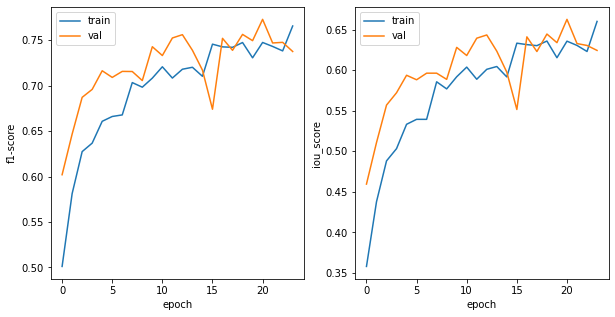

In [20]:
plot_history(model_vgg_unet)

# Predicting test image

In [21]:
reading_image = glob.glob(f"{out_test_data_dir}/Images/*.png")
reading_image[7]

reading_mask = glob.glob(f"{out_test_data_dir}/Masks/*.png")
# reading_mask[4]
reading_mask[7]


'D:/Users/juanp/Documents/NeuralNetworks/final-project-landandbuildingsatimg-ccny/data/processed/Cropped_same_name/test/Masks\\Batch_0_Image_12_Tile_2.png'

In [22]:
out = model.predict_segmentation(
    inp= reading_image[7],
    out_fname='Cropped_same_name/VGG_UNET_predictions/out.png'
)

In [23]:
img = PIL.Image.open(reading_image[7], 'r')
mask = PIL.Image.open(reading_mask[7], 'r')

mask_img = np.asarray(mask)
mask_img


array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 4, 4, 4],
       [1, 1, 1, ..., 4, 4, 4],
       [1, 1, 1, ..., 4, 4, 4]], dtype=uint8)

In [24]:
predicted_img = np.asarray(out)
predicted_img

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 1, ..., 2, 2, 2],
       [2, 1, 1, ..., 2, 2, 2],
       ...,
       [2, 1, 1, ..., 4, 4, 4],
       [2, 1, 1, ..., 4, 4, 4],
       [2, 1, 1, ..., 4, 4, 5]], dtype=int64)

## Plot Function

## Ploting the class labels

In [25]:
labels = pd.read_csv(f'{out_test_data_dir}/../class_dict.csv')['name'].values
col_dict = {0: 'blue', 1: 'red', 2: 'orange', 3: 'green', 
           4: 'yellow', 5: 'purple', 6: 'grey', }
labels

array(['unknown', 'urban_land', 'agriculture_land', 'rangeland',
       'forest_land', 'water', 'barren_land'], dtype=object)

## Joining the plots into 3 images

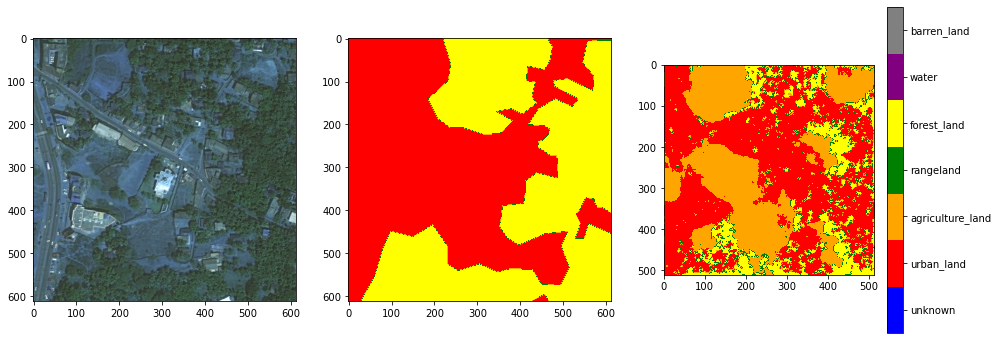

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

axes[0].imshow(np.asarray(img))
axes[1] = visualize.plot_label(mask_img, labels,col_dict, axes[1], fig, colorbar = False)
axes[2] = visualize.plot_label(predicted_img, labels,col_dict, axes[2], fig, colorbar = True)

## Sample_Weights

In [11]:
other_inputs_paths=[f"{bal_train_data_dir}/Sample_Weights/"]

for other_inputs_path in other_inputs_paths:
    print(other_inputs_path)

D:/Users/juanp/Documents/NeuralNetworks/final-project-landandbuildingsatimg-ccny/data/processed/Balanced_80/train/Sample_Weights/


In [12]:
ACCEPTABLE_IMAGE_FORMATS = [".jpg", ".jpeg", ".png", ".bmp", '.npy']
temp = []
for y, dir_entry in enumerate(os.listdir(other_inputs_path)):
                if os.path.isfile(os.path.join(other_inputs_path, dir_entry)) and \
                        os.path.splitext(dir_entry)[1] in ACCEPTABLE_IMAGE_FORMATS:
                    file_name, file_extension = os.path.splitext(dir_entry)

                    temp.append((file_name, file_extension,
                                 os.path.join(other_inputs_path, dir_entry)))

In [13]:
import itertools
from src.models.image_segmentation.keras_segmentation.data_utils.data_loader import get_pairs_from_paths

img_seg_pairs = get_pairs_from_paths(f"{bal_train_data_dir}/Images/", f"{bal_train_data_dir}/Masks/", other_inputs_paths=other_inputs_paths)
zipped = itertools.cycle(img_seg_pairs)



In [31]:
im, seg, others = next(zipped)
others, im, seg

(['D:/Users/juanp/Documents/NeuralNetworks/final-project-landandbuildingsatimg-ccny/data/processed/Balanced_80/train/Sample_Weights/Batch_0_Image_0_Tile_7.npy'],
 'D:/Users/juanp/Documents/NeuralNetworks/final-project-landandbuildingsatimg-ccny/data/processed/Balanced_80/train/Images/Batch_0_Image_0_Tile_7.png',
 'D:/Users/juanp/Documents/NeuralNetworks/final-project-landandbuildingsatimg-ccny/data/processed/Balanced_80/train/Masks/Batch_0_Image_0_Tile_7.png')

In [37]:
oth = []
for f in others:
    oth.append(np.load(temp[0][2]))

In [40]:
np.array(oth)

array([1])

In [11]:
np.ones([2]).shape

(2,)

In [23]:
others, im, seg

(['D:/Users/juanp/Documents/NeuralNetworks/final-project-landandbuildingsatimg-ccny/data/processed/Balanced_80/train/Sample_Weights/Batch_0_Image_0_Tile_1.npy'],
 'D:/Users/juanp/Documents/NeuralNetworks/final-project-landandbuildingsatimg-ccny/data/processed/Balanced_80/train/Images/Batch_0_Image_0_Tile_1.png',
 'D:/Users/juanp/Documents/NeuralNetworks/final-project-landandbuildingsatimg-ccny/data/processed/Balanced_80/train/Masks/Batch_0_Image_0_Tile_1.png')

In [38]:
os.listdir(other_inputs_path)

['Batch_0_Image_0_Tile_0.npy',
 'Batch_0_Image_0_Tile_1.npy',
 'Batch_0_Image_0_Tile_10.npy',
 'Batch_0_Image_0_Tile_11.npy',
 'Batch_0_Image_0_Tile_12.npy',
 'Batch_0_Image_0_Tile_15.npy',
 'Batch_0_Image_0_Tile_2.npy',
 'Batch_0_Image_0_Tile_4.npy',
 'Batch_0_Image_0_Tile_6.npy',
 'Batch_0_Image_0_Tile_7.npy',
 'Batch_0_Image_0_Tile_8.npy',
 'Batch_0_Image_0_Tile_9.npy',
 'Batch_0_Image_10_Tile_0.npy',
 'Batch_0_Image_10_Tile_1.npy',
 'Batch_0_Image_10_Tile_11.npy',
 'Batch_0_Image_10_Tile_12.npy',
 'Batch_0_Image_10_Tile_13.npy',
 'Batch_0_Image_10_Tile_2.npy',
 'Batch_0_Image_10_Tile_3.npy',
 'Batch_0_Image_10_Tile_5.npy',
 'Batch_0_Image_10_Tile_7.npy',
 'Batch_0_Image_10_Tile_8.npy',
 'Batch_0_Image_10_Tile_9.npy',
 'Batch_0_Image_11_Tile_0.npy',
 'Batch_0_Image_11_Tile_1.npy',
 'Batch_0_Image_11_Tile_10.npy',
 'Batch_0_Image_11_Tile_11.npy',
 'Batch_0_Image_11_Tile_14.npy',
 'Batch_0_Image_11_Tile_15.npy',
 'Batch_0_Image_11_Tile_2.npy',
 'Batch_0_Image_11_Tile_4.npy',
 'Batch_0